# Biliotecas

In [97]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
#pip install gymnasium[toy-text] imageio[ffmpeg]

In [98]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm            # barra de progresso
print(gym.__version__)

1.1.1


# Implementação do Q-learning

In [139]:
def executar_episodio_guloso(
    env: gym.Env,                 # ambiente já instanciado
    Q: np.ndarray,                # tabela Q (shape: |S| × |A|)
    max_steps: int = 1_000        # limite de passos por segurança
) -> Tuple[float, int]:
    """
    Executa 1 episódio usando política determinística gulosa (ação = argmax_a Q(s,a)) e devolve a recompensa acumulada e o número de passos.
    O laço termina se ocorrer qualquer destas condições:
    1. `terminated`  – objetivo alcançado, segundo o ambiente.
    2. `truncated`   – limite de passos imposto por `TimeLimit`.
    3. Queda no penhasco (`reward == -100`), caso específico do Cliff Walking.
    4. Número de passos ≥ `max_steps`.
    """
    s, _ = env.reset()            # estado inicial
    ret: float = 0.0              # recompensa acumulada
    steps: int = 0                # contador de passos

    # laço limitado a `max_steps`
    for _ in range(max_steps):
        a: int = int(np.argmax(Q[s]))          # ação gulosa
        s, r, term, trunc, _ = env.step(a)     # transição ambiente
        ret   += float(r)                      # acumula recompensa
        steps += 1                             # incrementa passo

        cliff: bool = (r == -100)              # caiu no precipício? (ambiente Cliff Walking)
        if term or trunc or cliff:             # condição de parada
            break

    return ret, steps


def q_learning(
    env: gym.Env,                 # ambiente Gymnasium
    episodes: int,                # número total de episódios
    alpha: float,                 # taxa de aprendizado (passo do gradiente TD)
    gamma: float,                 # fator de desconto
    epsilon: float                # epsilon fixo da política comportamental
) -> Tuple[np.ndarray,
           List[int],
           List[float],
           Dict[int, np.ndarray]]:
    """
    Retorna
    -------
    q_table          : np.ndarray           – matriz |S| × |A| com valores Q
    episodio_len     : list[int]            – número de passos dos episódio
    episodio_return  : list[float]          – retorno total dos episódio
    target_policy    : dict[int, np.ndarray]– política determinística gulosa final
    """

    # Inicializa a tabela Q com zeros
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    
    # Listas para armazenar métricas de avaliação
    episodio_len = []
    episodio_return = []
    
    # Loop principal do Q-learning
    for episode in range(episodes):
        # Reinicia o ambiente
        state, _ = env.reset()
        
        # Executa um episódio completo usando epsilon-greedy para treinamento
        for step in range(1000):  # limite de passos para evitar loops infinitos
            # Política epsilon-greedy: exploração vs exploração
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # ação aleatória (exploração)
            else:
                action = np.argmax(q_table[state])  # ação gulosa (exploração)
            
            # Executa a ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Atualização Q-learning: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
            best_next_action = np.argmax(q_table[next_state])
            q_table[state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[state, action]
            )
            
            # Atualiza o estado atual
            state = next_state
            
            # Verifica condições de parada
            if terminated or truncated or reward == -100:  # caiu no precipício (Cliff Walking)
                break
        
        # Avalia a política gulosa atual ao final de cada episódio
        ret, steps = executar_episodio_guloso(env, q_table)
        episodio_len.append(steps)
        episodio_return.append(ret)
    
    # Constrói a política determinística gulosa final
    target_policy = {}
    for s in range(n_states):
        # Política gulosa: probabilidade 1 para a melhor ação, 0 para as demais
        policy_vector = np.zeros(n_actions)
        best_action = np.argmax(q_table[s])
        policy_vector[best_action] = 1.0
        target_policy[s] = policy_vector
    
    return q_table, episodio_len, episodio_return, target_policy

# Visualização

In [140]:
def plotar_metricas(
    episodio_len: list[int],          # lista com o número de passos de cada episódio
    episodio_return: list[float],     # lista com a recompensa total de cada episódio
    janela: int = 100                 # tamanho da janela da média móvel
) -> None:
    # Plot duração do episódio por episódio e a recompensa total por episodio.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodio_len, label='Comprimento do Episódio', color='blue')
    plt.xlabel('Episódio')
    plt.ylabel('Comprimento')
    plt.title('Comprimento do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodio_return, label='Retorno do Episódio', color='green')
    plt.xlabel('Episódio')
    plt.ylabel('Retorno')
    plt.title('Retorno do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [141]:
ARROWS = {
    "FrozenLake-v1":  ['←', '↓', '→', '↑'],  # 0=Left, 1=Down, 2=Right, 3=Up
    "CliffWalking-v0": ['↑', '→', '↓', '←']  # 0=Up,   1=Right, 2=Down,  3=Left
}

def visualizar_politica(
    env,
    politica: Dict[int, np.ndarray],    # mapeamento estado → vetor de probabilidades (|A|)
    shape: tuple[int, int]              # (linhas, colunas) da grade
) -> None:
    """
    Desenha, com Matplotlib, histogramas das distribuições de probabilidade
    de cada ação em cada estado de um ambiente toy-text do gymnasium.

    Parâmetros
    ----------
    env : gymnasium.Env
        Ambiente já instanciado.
    politica : Dict[int, np.ndarray]
        Dicionário onde cada chave é um inteiro de estado e cada valor é um vetor 1-D com a distribuição epsilon-gulosa (ou gulosa) sobre as ações.
    shape : tuple[int, int]
        Formato da grade (número de linhas, número de colunas) para montagem dos subgráficos.
    """
    # Descobre o id do ambiente original
    id_env: str = env.unwrapped.spec.id

    # Seleciona os rótulos de setas apropriados
    try:
        direcoes: list[str] = ARROWS[id_env]
    except KeyError:                     # ambiente não mapeado
        raise ValueError(f"Ambiente “{id_env}” não suportado.")

    # Número de ações
    n_acoes: int = len(direcoes)
    acoes: np.ndarray = np.arange(n_acoes)  # [0, 1, 2, 3]

    # Cria grid de subplots: uma subplot por estado
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(3 * shape[1], 2.2 * shape[0]))
    axs = axs.flatten()  # facilita indexação linear

    # Percorre cada estado existente na política
    for s, ax in enumerate(axs):
        pi: np.ndarray = politica[s]            # vetor de probabilidades

        # Desenha barra com a probabilidade de cada ação
        ax.bar(acoes, pi, color='gray')

        # Configurações do eixo x
        ax.set_xticks(acoes)
        ax.set_xticklabels(direcoes)

        # Limites e ticks do eixo y
        ax.set_ylim(0, 1.05)
        ax.set_yticks([0, 0.5, 1])

        # Título identifica o número do estado
        ax.set_title(f"Estado {s}")

    # Ajusta layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

In [142]:
def gerar_gif(
    politica: Dict[int, np.ndarray],             # estado → distribuição sobre ações
    env: gym.Env,                                # ambiente com render_mode='rgb_array'
    path_gif: str,                               # caminho/arquivo de saída (.gif)
    n_episodios: int = 5                         # quantos episódios filmar
) -> str:
    """
    Executa `n_episodios` usando a política fornecida (epsilon-gulosa ou gulosa) e gera um GIF mostrando a trajetória do agente.

    Parâmetros
    ----------
    politica : Dict[int, np.ndarray]
        Para cada estado `s`, deve conter um vetor 1-D com as probabilidades de selecionar cada ação `a`.
    env : gymnasium.Env
        Ambiente já instanciado com `render_mode='rgb_array'`, pois `env.render()` retornará frames numéricos (arrays de pixels).
    path_gif : str
        Caminho completo do arquivo a ser salvo (ex.: `"trajetoria.gif"`).
    n_episodios : int, opcional (default=5)
        Número de episódios que serão simulados/gravados.

    Retorno
    -------
    str
        O mesmo `path_gif` recebido, para encadeamento ou conferência.
    """

    frames: list[np.ndarray] = []                         # armazena todos os frames
    n_actions: int = env.action_space.n


    # --------------- coleta de frames ---------------
    for _ in range(n_episodios):
        state, _ = env.reset()                   # reinicia o ambiente
        for _ in range(100):                     # limite de passos p/ não travar
            # escolhe ação segundo a política
            action = np.random.choice(n_actions, p=politica[state])

            # executa ação e obtém próxima transição
            state, _, terminated, truncated, _ = env.step(action)

            # captura frame após passo do agente
            frames.append(env.render())

            # interrompe se objetivo alcançado (terminated) ou TimeLimit/erro (truncated)
            if terminated or truncated:
                break

    env.close()                                  # libera recursos do ambiente

    # --------------- salva GIF ---------------
    imageio.mimsave(path_gif, frames, format="GIF", fps=2)

    return path_gif                              # devolve caminho do arquivo

# Simulação

In [143]:
# Configura o ambiente (ajustado para ser mais viável para aprendizado)
map_name = '8x8'  # Ambiente mais simples para demonstração
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # mantém o desafio, mas em ambiente menor
env = gym.make("FrozenLake-v1", map_name=map_name, render_mode=render_mode, is_slippery=is_slippery)

In [149]:
# Hiper-parâmetros principais (otimizados para FrozenLake 4x4)
EPISODIOS = 10000     # @param {type:"integer"} - Suficiente para ambiente 4x4
ALPHA     = 0.1       # @param {type:"number"} - Alpha menor para estabilidade
GAMMA     = 0.9      # @param {type:"number"} - Gamma alto para valorizar recompensas futuras
EPSILON   = 0.9       # @param {type:"number"} - Epsilon inicial alto para exploração

In [154]:
# Q-learning
q_tab, ep_len, ep_ret, pi_eps = q_learning(
    env,
    episodes = EPISODIOS,
    alpha    = ALPHA,
    gamma    = GAMMA,
    epsilon  = EPSILON
)
print(pi_eps)

{0: array([0., 0., 1., 0.]), 1: array([0., 0., 1., 0.]), 2: array([0., 0., 1., 0.]), 3: array([0., 0., 1., 0.]), 4: array([0., 1., 0., 0.]), 5: array([0., 0., 1., 0.]), 6: array([0., 1., 0., 0.]), 7: array([0., 1., 0., 0.]), 8: array([0., 0., 1., 0.]), 9: array([0., 0., 1., 0.]), 10: array([0., 0., 1., 0.]), 11: array([0., 0., 1., 0.]), 12: array([0., 0., 1., 0.]), 13: array([0., 0., 1., 0.]), 14: array([0., 0., 1., 0.]), 15: array([0., 1., 0., 0.]), 16: array([0., 0., 1., 0.]), 17: array([0., 1., 0., 0.]), 18: array([0., 1., 0., 0.]), 19: array([1., 0., 0., 0.]), 20: array([0., 0., 1., 0.]), 21: array([0., 0., 1., 0.]), 22: array([0., 0., 1., 0.]), 23: array([0., 1., 0., 0.]), 24: array([0., 0., 1., 0.]), 25: array([0., 0., 1., 0.]), 26: array([0., 0., 1., 0.]), 27: array([0., 0., 1., 0.]), 28: array([0., 1., 0., 0.]), 29: array([1., 0., 0., 0.]), 30: array([0., 0., 1., 0.]), 31: array([0., 1., 0., 0.]), 32: array([0., 0., 0., 1.]), 33: array([0., 0., 0., 1.]), 34: array([0., 0., 0., 

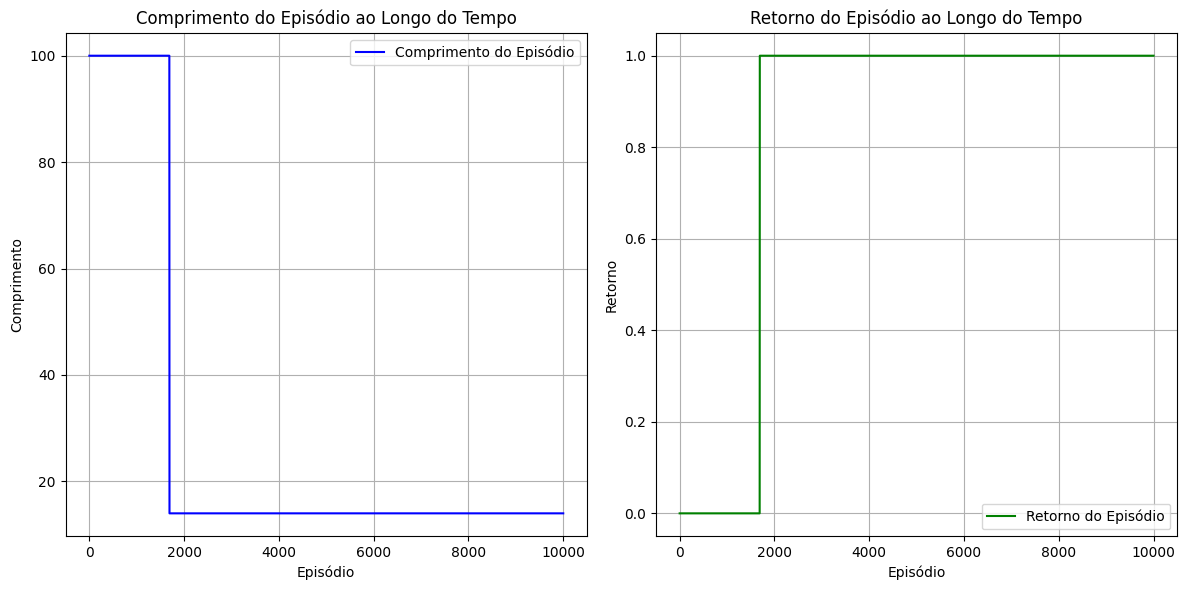

In [157]:
plotar_metricas(ep_len, ep_ret, janela=1000)

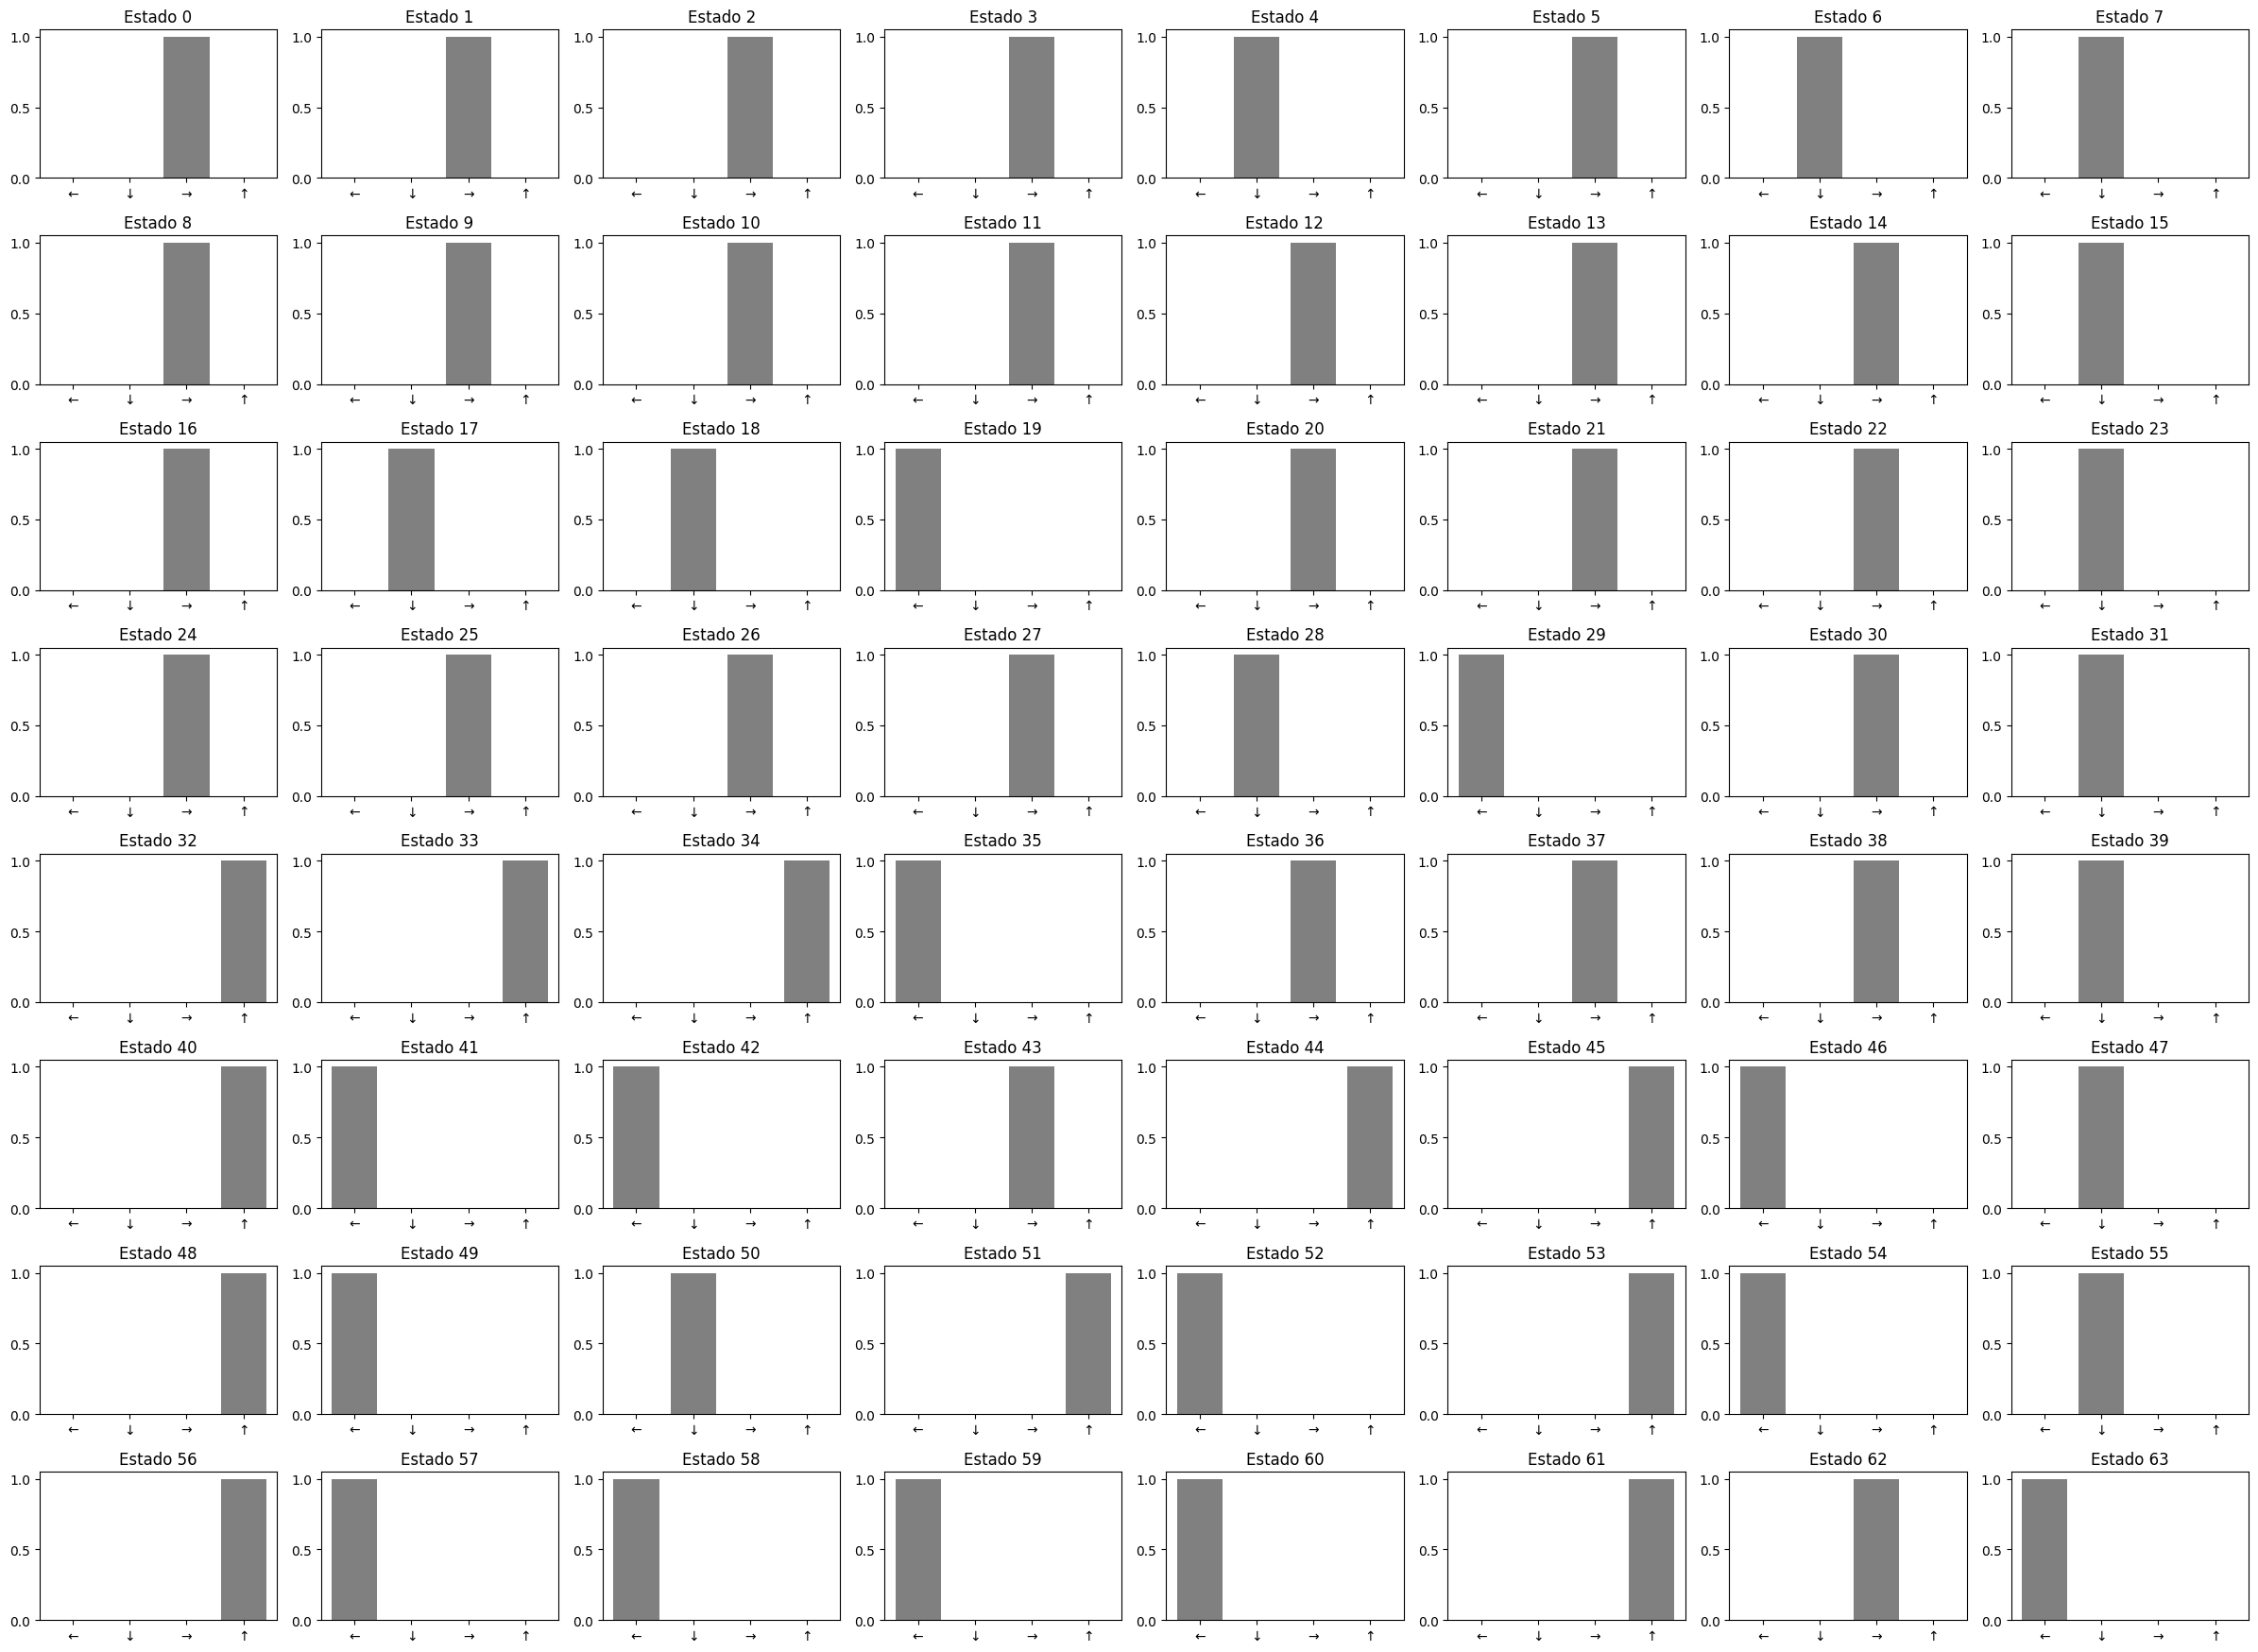

In [158]:
visualizar_politica(env, pi_eps, shape=(8, 8))

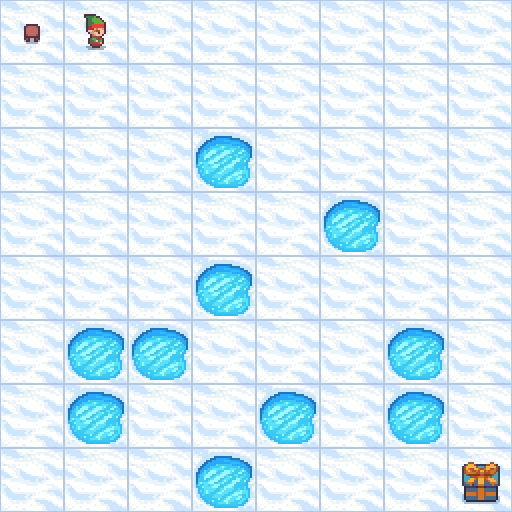

In [159]:
# Recria ambiente para renderizar
id="FrozenLake-v1"
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # torna o ambiente determinístico ou estocástico
map_name = "8x8"
env = gym.make(id=id, render_mode=render_mode, is_slippery=is_slippery, map_name=map_name)

# Gera o GIF
gif_path = "politica_epsilon_gulosa.gif"
gif_path = gerar_gif(pi_eps, env, path_gif="frozenlake_qlearning.gif", n_episodios=5)

# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa:

1. Implemente o algoritmo Q-learning.
2. Considere os 4 hiperparametros (EPISODIOS, ALPHA, GAMMA, EPSILON)
- Varie um dos hiperparametros (ex.: EPISODIOS) e fixe os demais (ex.: ALPHA, GAMMA, EPSILON).
- Plote a duração do episódio por episódio e também a recompensa total por episodio (ambas relativas à política alvo determinística gulosa - utilizar a função ``executar_episodio_guloso`` no final de cada episódio) para cada estudo de hiperparâmetro.
- Observação: as curvas para cada estudo de hiperparâmetro devem estar na mesma figura, isto é, se o hiperparâmetro a ser variado é o EPSILON com 4 valores, entao o gráfico de duração do episódio deve mostrar as 4 curvas relativas a cada valor de EPSILON (com legenda) e de maneira similar para a recompensa total por episodio.
3. Repita o procedimento para cada um dos hiperparametros.
4. Reporte suas observações.